In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import joblib

In [ ]:
df = pd.read_csv("processed_dataset.csv")

feature_columns = ["url_len", "num_unsafe_chars", "num_digits", "num_subdomains",
                   "is_ip", "num_params", "num_slashes", "contains_suspicious_keywords",
                   "contains_suspicious_file_extension", "short_url", "url_entropy"]

X = df[feature_columns]
y = df["type"] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

**Logistc Regression**

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [15]:
model = make_pipeline(StandardScaler(), 
                      LogisticRegression(solver='saga', max_iter=3000, random_state=10))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("LogisticRegression Model Accuracy: ", accuracy_score(y_test, y_pred))
print("classification_report: \n", classification_report(y_test, y_pred))

LogisticRegression Model Accuracy:  0.8398252443584487
classification_report: 
               precision    recall  f1-score   support

      benign       0.85      0.97      0.91     85829
  defacement       0.81      0.85      0.83     19299
     malware       0.83      0.55      0.66      6383
    phishing       0.75      0.33      0.46     18728

    accuracy                           0.84    130239
   macro avg       0.81      0.67      0.71    130239
weighted avg       0.83      0.84      0.82    130239



In [17]:
joblib.dump(model, "models\Logistic_model.pkl")
print("Model saved.")

Model saved.


Note: Performance of logistic regression is impacted due to the presence of outliers and class imbalance. We can shift to trees to overcome this.

**Random Forest Classifier**

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model_forest = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=10)
model_forest.fit(X_train, y_train)

y_pred_forest = model_forest.predict(X_test)

print("RandomForestClassifier Model Accuracy: ", accuracy_score(y_test, y_pred_forest))
print("classification_report: \n", classification_report(y_test, y_pred_forest))

RandomForestClassifier Model Accuracy:  0.938628214282972
classification_report: 
               precision    recall  f1-score   support

      benign       0.96      0.97      0.97     85829
  defacement       0.94      0.96      0.95     19299
     malware       0.96      0.92      0.94      6383
    phishing       0.83      0.77      0.80     18728

    accuracy                           0.94    130239
   macro avg       0.92      0.91      0.91    130239
weighted avg       0.94      0.94      0.94    130239



In [46]:
joblib.dump(model_forest, "models\Random_forest_model.pkl")
print("Model saved.")

Model saved.


**LightGBM Classifier**

In [43]:
from lightgbm import LGBMClassifier, early_stopping

In [44]:
model_lgbm = LGBMClassifier(
    objective='multiclass',
    num_class=4,
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=10,
    reg_alpha=0.5,
    reg_lambda=0.5,
    class_weight='balanced',
    random_state=10
)

model_lgbm.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          callbacks=[early_stopping(stopping_rounds=50)]
          )

y_pred_lgbm = model_lgbm.predict(X_test,  num_iteration=model_lgbm.best_iteration_)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 818
[LightGBM] [Info] Number of data points in the train set: 520952, number of used features: 11
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_logloss: 0.225928


In [45]:
print("LGBMClassifier Model Accuracy: ", accuracy_score(y_test, y_pred_forest))
print("classification_report: \n", classification_report(y_test, y_pred_forest))

LGBMClassifier Model Accuracy:  0.94288193244727
classification_report: 
               precision    recall  f1-score   support

      benign       0.96      0.98      0.97     85829
  defacement       0.94      0.96      0.95     19299
     malware       0.96      0.92      0.94      6383
    phishing       0.86      0.76      0.81     18728

    accuracy                           0.94    130239
   macro avg       0.93      0.91      0.92    130239
weighted avg       0.94      0.94      0.94    130239



In [47]:
joblib.dump(model_lgbm, "models\LightGBM_model.pkl")
print("Model saved.")

Model saved.


Note: Random Forest and LightGBM classifier both result in 94 percent accuracy despite extensive tuning (LightGBM performs slightly better). Therefore, either models can be considered suitable for malicious URL detection. 

**Confusion Matrix for LightGBM**

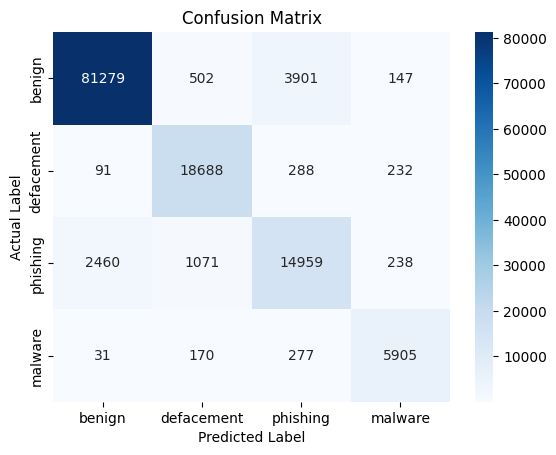

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

labels = ["benign", "defacement", "phishing", "malware"]
cm = confusion_matrix(y_test, y_pred_lgbm, labels=labels)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()